In [1]:
import numpy as np
import scipy.stats as sps
import matplotlib.pyplot as plt
from functools import reduce
from heapq import heappush, heappop
from sklearn.neighbors import KNeighborsClassifier
from sklearn.datasets import make_classification, make_moons
from scipy.sparse import issparse
from scipy.spatial.distance import cosine, minkowski

%matplotlib inline

Напишем какую-то реализацию предложенного эксперимента, сравним его с простым knn на разных выборках.

Попробуем следующие модификации:
* когда определяем самые надежно классифицированные элементы, можем брать каждый раз какой-то процент от них, либо какое-то константное количество элементов
* надежность можно считать, как предложено, то есть брать долю самого многочисленного класса, но эта характеристика не учитывает расстояние до элементов. Можно воспользоваться weighted knn

Заметим, что когда данные достаточно полно описывают классы, данный алгоритм работает почти в точности как knn, потому что новоразмеченные векторы находятся там же, где и размеченные и новой информации не дают. Так что, этот метод нужен только там, где данных очень мало и мы почему-то считаем, что он сможет выделить структуру классов подходящим образом.

In [2]:
class IterativeKnn:
    def __init__(self, vs, classes, k, dist, step_conf, flavor):
        self.vs = vs
        self.classes = classes.copy()
        self.k = k
        self.dist = dist
        self.step_conf = step_conf
        self.flavor = flavor
        
        self.knns = {i: ([], np.zeros(max(self.classes) + 1)) 
                     for i, cls in enumerate(self.classes) if cls == -1}
        
        for i, cls in enumerate(self.classes):
            if cls != -1:
                self.relax(i)
                
    def v(self, index):
        v = self.vs[index]
        
        if issparse(self.vs):
            v = v.todense()
            
        return v

    def relax(self, index):
        if index in self.knns:
            del self.knns[index]
        
        v = self.v(index)
        cls = self.classes[index]
        
        for i, (knn, cls_counts) in self.knns.items():
            d = -self.dist(v, self.v(i))
            
            heappush(knn, (d, index))
            cls_counts[cls] += 1 if self.flavor == 'proportion' else -1 / d
            
            if len(knn) > self.k:
                max_d, max_index = heappop(knn)
                cls_counts[self.classes[max_index]] -= 1 if self.flavor == 'proportion' else -1 / max_d
                
    def step(self):
        if self.step_conf['type'] == 'percentile':   
            confident_num = max(1, int(len(self.knns) * self.step_conf['percentile']))
        elif self.step_conf['type'] == 'const':
            confident_num = self.step_conf['const']

        inds = list(sorted((cls_counts.max() / (cls_counts.sum() if self.flavor == 'proportion' else 1), i) 
                           for i, (knn, cls_counts) in self.knns.items()))[-confident_num:]
        for _, i in inds:
            self.classes[i] = self.knns[i][1].argmax()
            
        for _, i in inds:
            self.relax(i)
    
    def classify(self):
        while len(self.knns) != 0:
            self.step()
            
        return self.classes

Напишем несколько функций, которые будут рисовать классификацию на нескольких игрушечных датасетах. Заголовки графиков ниже означают следующее:
* true -- размеченная выборка
* splitted -- выборка, поделенная на train/test, элементы, попавшие в test помечены черным
* percentile_proportion_iknn -- итеративный knn, который на каждой итерации добавляет некоторую долю самых надежных, а надежность определяет как отношение числа ближайших соседей из доминирующего класса к числу ближайших соседей
* const_weighted_iknn -- итеративный knn, который на каждой итерации добавляет константное число самых надежных, а надежность для вектора $v_0$ класса $i$ определяет как $\sum\limits_{\substack{c(v)\ =\ i,\\v\ \in\ knn(v_0)}} \frac{1}{dist(v, v_0)^2}$
* percentile_weighted_iknn -- аналогично
* const_proportion_iknn -- аналогично
* uniform_knn -- обычный knn
* weighted_knn -- weighted knn

In [3]:
cols = ['k', 'b', 'r', 'g', 'm']
n_neighbours = 5

PERCENTILE_CONF = {
    'type': 'percentile',
    'percentile': 0.02
}

CONST_CONF = {
    'type': 'const',
    'const': 2
}

def compare_for_gaussians(random_sampling=True):
    X, y = make_classification(n_samples=700, n_features=2, n_informative=2, 
                               n_redundant=0, n_classes=4, n_clusters_per_class=1)
    compare(X, y, random_sampling)
    
    
def compare_for_moons(noise, random_sampling=True):
    X, y = make_moons(400, noise=noise, random_state=np.random.randint(1000))
    compare(X, y, random_sampling)
    

def tt_split(true_classes, vs, percentile=0.9, random_sampling=True):
    classes = true_classes.copy()
    result_test_inds = np.array([], dtype=np.int64)
        
    cls_num = classes.max() + 1
    N = max(1, int(len(classes) / cls_num * percentile))
    
    for cls in range(cls_num):
        mask = classes == cls
        inds = np.arange(len(classes))[mask]
        cls_N = max(1, min(N, int(len(inds) * percentile)))
        
        if random_sampling:
            test_inds = np.random.choice(inds, cls_N, replace=False)
        else:
            _, close_inds = zip(*list(sorted(zip(np.linalg.norm(vs[mask], axis=1), inds)))[:cls_N])
            test_inds = np.array(close_inds)
            
        result_test_inds = np.append(result_test_inds, test_inds)
        classes[test_inds] = -1
        
    return classes, np.sort(result_test_inds)

    
def compare(vs, true_classes, random_sampling):
    vs -= vs.mean()
    
    classes, _ = tt_split(true_classes, vs, 0.9, random_sampling)

    iknn_classes = [(IterativeKnn(vs, classes, n_neighbours, minkowski, step_conf, flavor).classify(), 
                     '{}_{}_iknn'.format(step_conf['type'], flavor))
                    for step_conf in [PERCENTILE_CONF, CONST_CONF] 
                    for flavor in ['proportion', 'weighted']]

    knn_classes = []
    for weights in ['uniform', 'distance']:
        knn_classifier = KNeighborsClassifier(n_neighbors=n_neighbours, weights=weights)
        mask = classes != -1
        knn_classifier.fit(vs[mask], true_classes[mask])
        knn_classes_ = classes.copy()
        knn_classes_[~mask] = knn_classifier.predict(vs[~mask])
        
        knn_classes.append((knn_classes_, '{}_knn'.format(weights)))

    fig, ax = plt.subplots(4, 2, figsize=(20, 10))
    ax = ax.reshape(-1)

    for i, (clss, name) in enumerate([(true_classes, 'true'), 
                                      (classes, 'splitted')] + iknn_classes + knn_classes):
        ax[i].set_title(name)
        ax[i].scatter(*zip(*vs), s=50, c=[cols[c + 1] for c in clss])
        
    plt.show()

Алгоритм, по тому как он, потихоньку отталкиваясь от размеченных, точек начинает поедать пространство, немного напоминает DBSCAN. Он должен лучше работать на классах сложной формы, потому что в отличие от простого knn, он сможет уловить более сложную пространственную информацию.

TRIAL


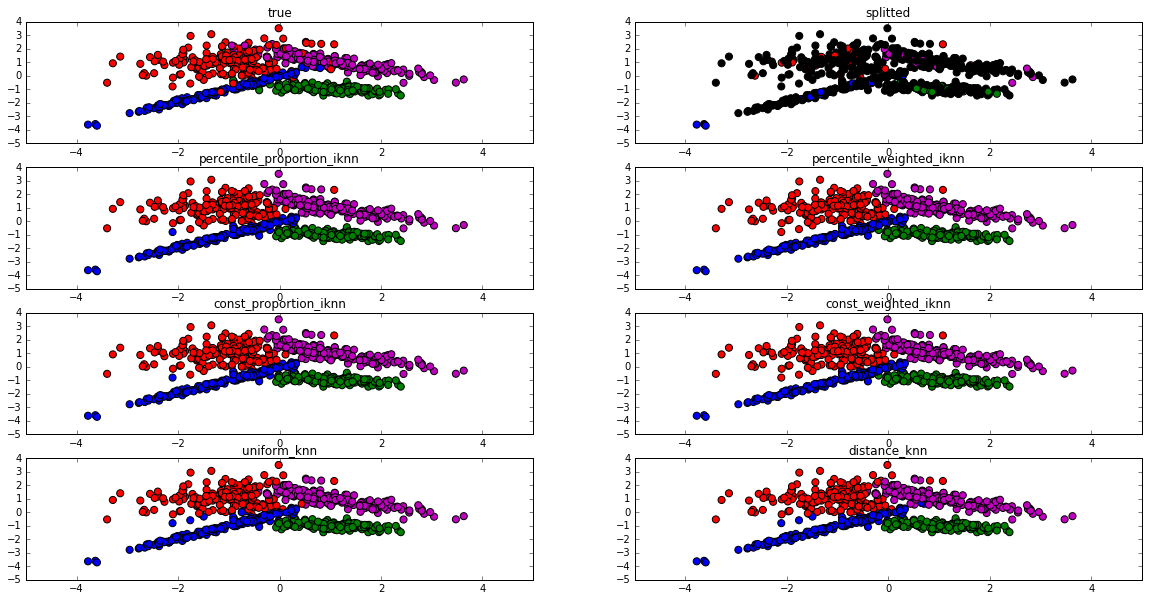

TRIAL


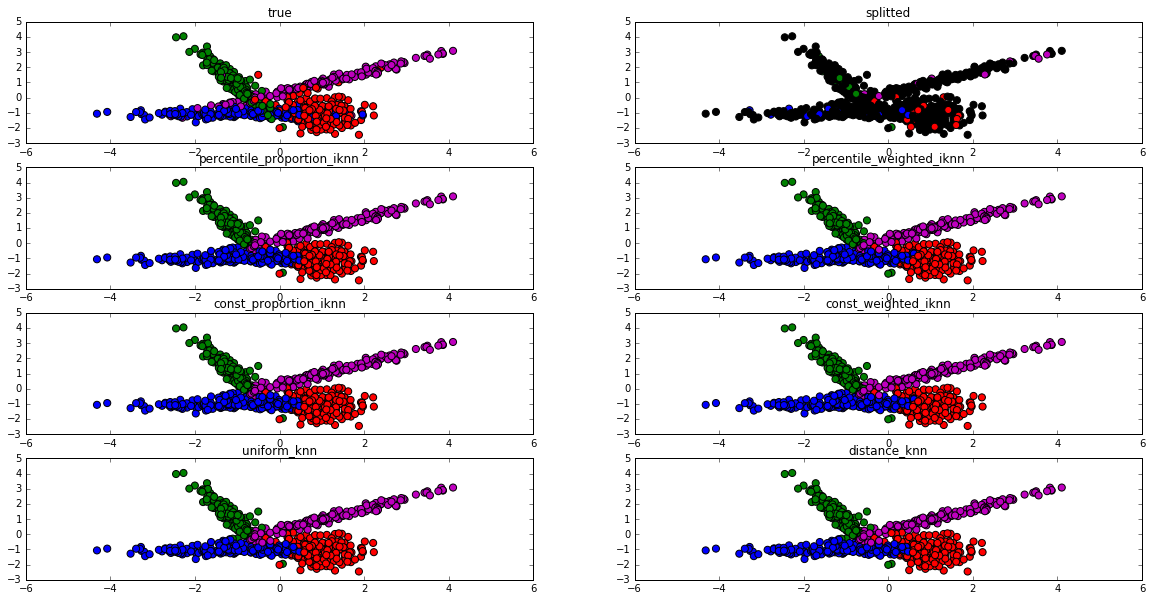

In [4]:
for _ in range(2):
    print('TRIAL')
    compare_for_gaussians()

Пометим классифицированными элементы с максимальной нормой, тут итеративный алгоритм должен лучше уловить форму.

TRIAL


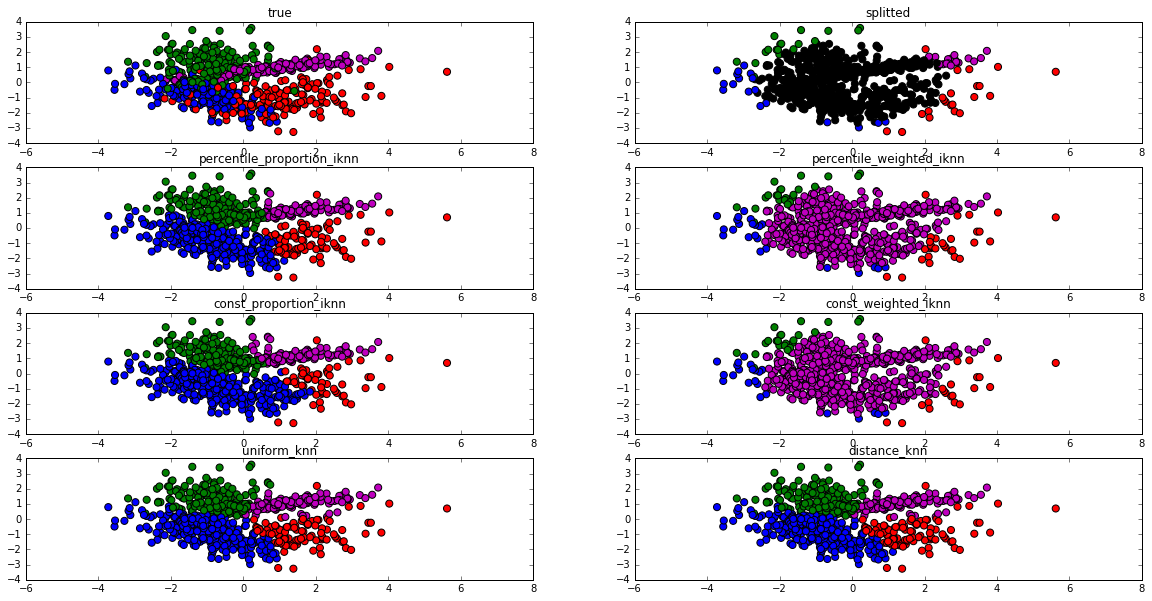

TRIAL


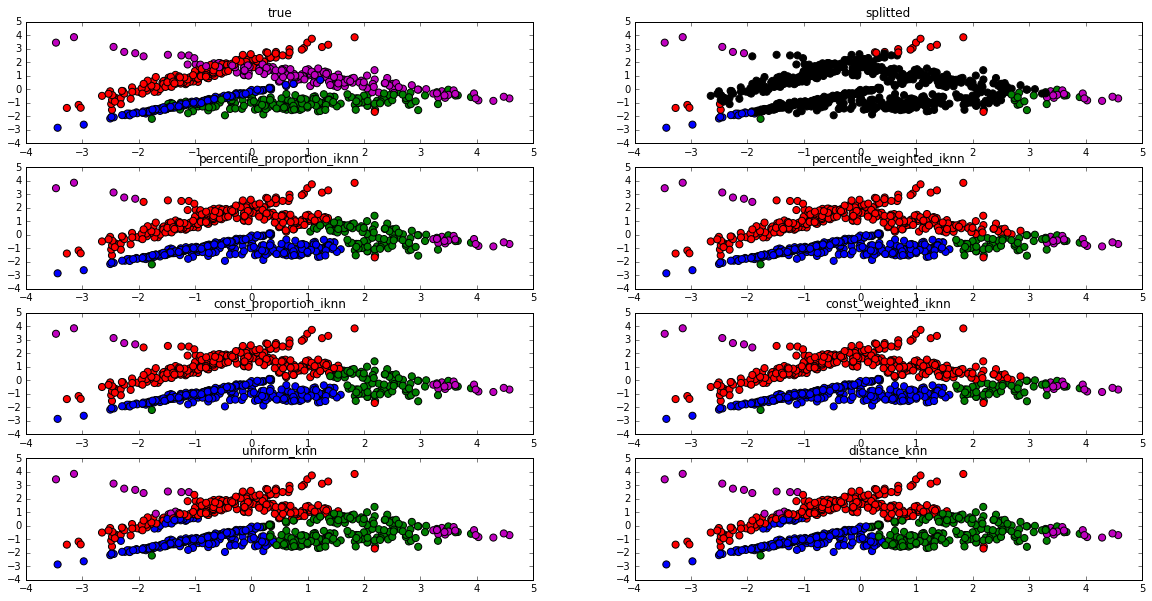

In [5]:
for _ in range(2):
    print('TRIAL')
    compare_for_gaussians(random_sampling=False)

Непонятно, что лучше, все зависит от формы кластеров, куда попали размеченные объекты и так далее.

Попробуем классы более сложной формы.

TRIAL


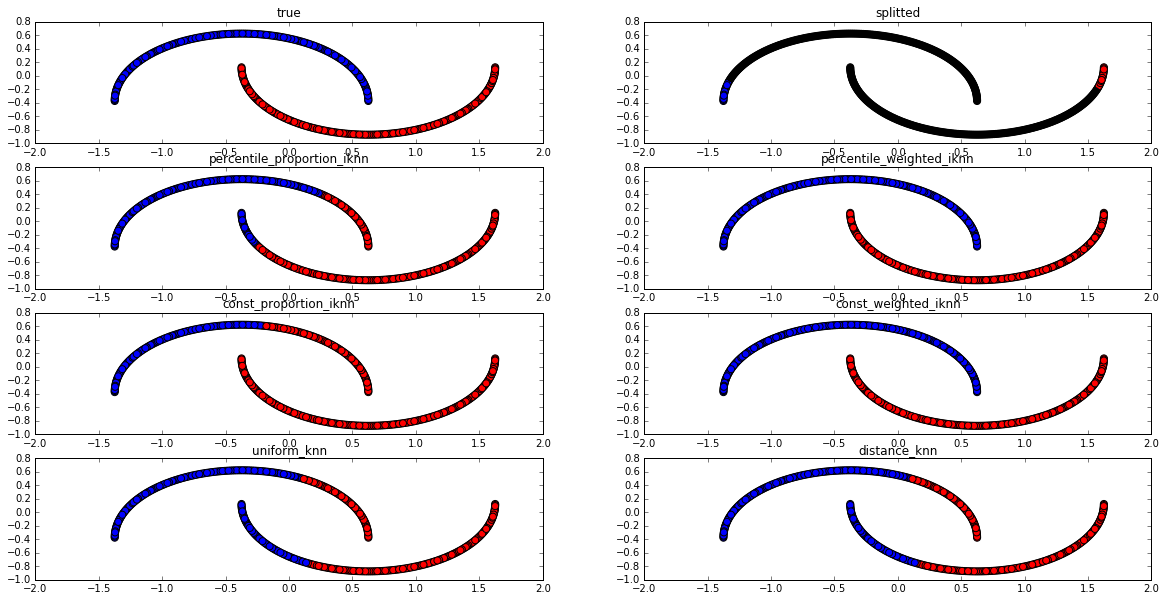

TRIAL


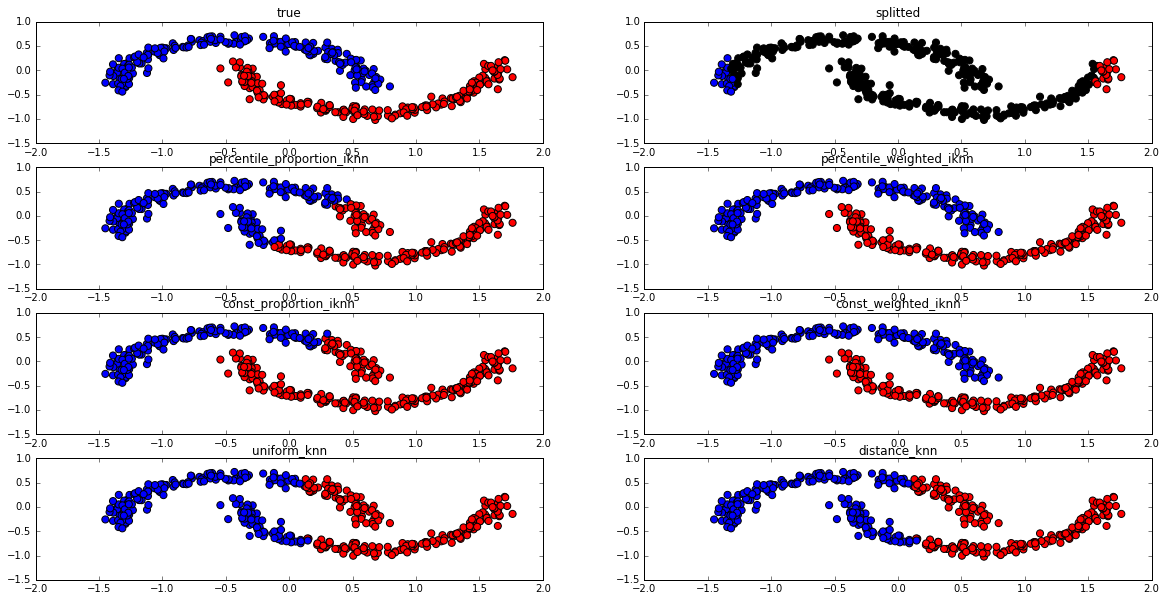

TRIAL


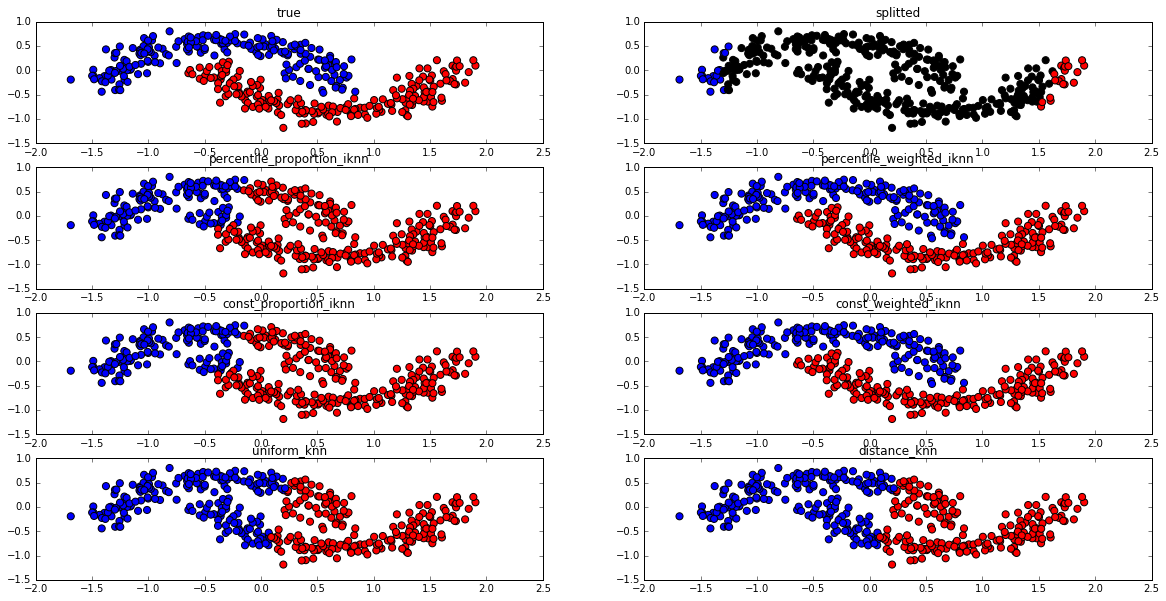

TRIAL


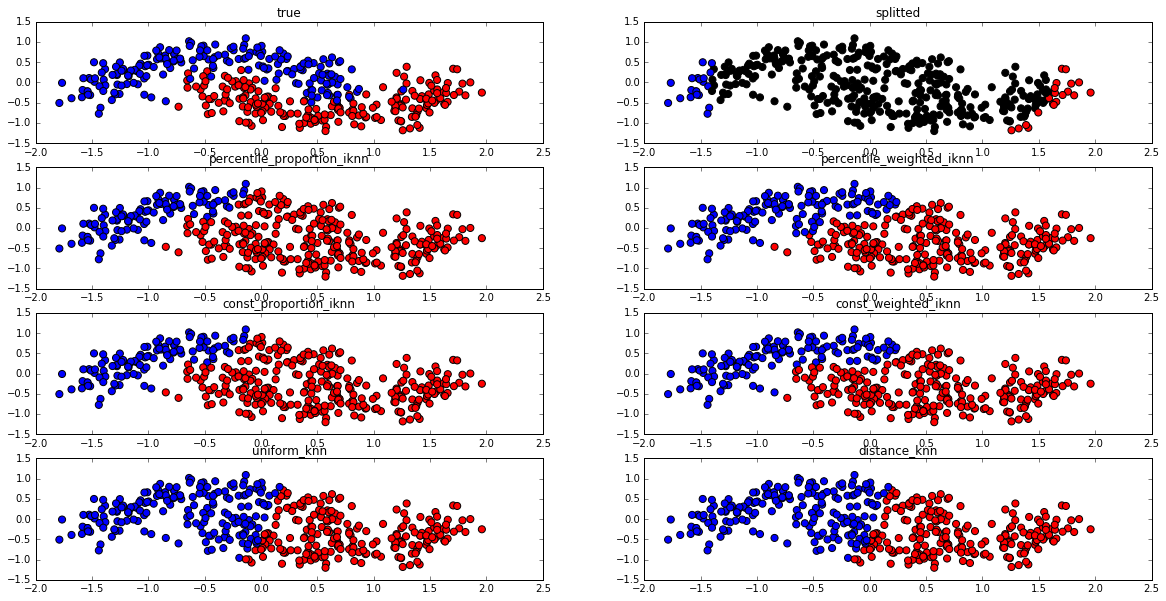

In [6]:
for noise in np.arange(0, 0.2, 0.066):
    print('TRIAL')
    compare_for_moons(noise, random_sampling=False)

Тут лучше всего справляется percentile_weighted_iknn.

Попробуем const_proportion_iknn на 20newsgroups. То что сейчас написано работает долго, поэтому будем пробовать на маленьком куске. Попробуем tf-idf, word2vec. Также попробуем train/test 1/1 и 9/1. Будем сравниваться с weighted knn и логрегрессией. 

In [7]:
from sklearn.datasets import fetch_20newsgroups
from sumy.nlp.stemmers import Stemmer
import nltk
import gensim
from collections import Counter

from sklearn.metrics import accuracy_score

from gensim.models.keyedvectors import KeyedVectors

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression

In [8]:
newsgroups_train = fetch_20newsgroups(subset='train')

In [9]:
data = newsgroups_train['data']
target = newsgroups_train['target']

In [10]:
tk = nltk.tokenize.TweetTokenizer()

In [11]:
stemmer = Stemmer('english')
data = [' '.join(map(stemmer, tk.tokenize(line.lower()))) for line in data]

In [12]:
l = list(zip(data, target))
np.random.shuffle(l)
data, target = [list(e) for e in zip(*l)]

In [16]:
def tfidf(docs):
    return TfidfVectorizer(tokenizer=lambda x: x.split()).fit_transform(docs), 'tfidf'

def smth2vec(docs):
    tv = TfidfVectorizer(tokenizer=lambda x: x.split())
    tfidf = tv.fit_transform(docs)
    
    embeddings = KeyedVectors.load_word2vec_format('vs.bin', binary=True)
        
    result = np.zeros((len(docs), embeddings.vector_size))
    
    for i, doc in enumerate(docs):
        vecs = [embeddings[word] * tfidf[i, tv.vocabulary_[word]] 
                for word in doc.split() if word in embeddings.vocab]
        
        if vecs:
            result[i,:] = np.mean(vecs, axis=0)
        else:
            result[i,0] = 1
        
    return result, 'smth'

def trial(test_part, size):
    trial_data, trial_target = data[:size], np.array(target[:size])
    
    print('class disbalance check: {}'.format([round(num / len(trial_target), 2) 
                                               for _, num in Counter(trial_target).items()]))
    
    vec_types = [tfidf(trial_data), smth2vec(trial_data)]
    
    classes, test_inds = tt_split(trial_target, None, test_part, True)
    mask = np.full((len(trial_target),), False)
    mask[test_inds] = True
    
    for vecs, vec_type in vec_types:
        X_train, X_test, y_train, y_test = vecs[~mask], vecs[mask], trial_target[~mask], trial_target[mask]
        preds = []

        iknn = IterativeKnn(vecs, classes, 5, cosine if vec_type == 'smth' else minkowski, 
                            {'type': 'const', 'const': 10}, 'proportion').classify()
        preds.append((iknn[test_inds], 'iknn'))
        
        for model, name in [(KNeighborsClassifier(n_neighbors=5, weights='distance', 
                                                  metric='cosine' if vec_type == 'smth' else 'minkowski'), 'knn'), 
                            (LogisticRegression(), 'logregression')]:
            model.fit(X_train, y_train)
            preds.append((model.predict(X_test), name))
            
        print('For vec_type {}:'.format(vec_type))
        for y_pred, name in preds:
            print('accuracy_score for {} is {}'.format(name, accuracy_score(y_test, y_pred)))

In [17]:
for test_part, size in [(0.1, 5000), (0.5, 3000)]:
    print('Test part {}, size {}'.format(test_part, size))
    
    trial(test_part, size)

Test part 0.1, size 5000
class disbalance check: [0.06, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.04, 0.05, 0.04, 0.05, 0.05, 0.05, 0.06, 0.06, 0.03, 0.05]
For vec_type tfidf:
accuracy_score for iknn is 0.5966386554621849
accuracy_score for knn is 0.6428571428571429
accuracy_score for logregression is 0.8361344537815126
For vec_type smth:
accuracy_score for iknn is 0.4411764705882353
accuracy_score for knn is 0.46008403361344535
accuracy_score for logregression is 0.21428571428571427
Test part 0.5, size 3000
class disbalance check: [0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.04, 0.05, 0.05, 0.06, 0.05, 0.05, 0.03, 0.05]
For vec_type tfidf:
accuracy_score for iknn is 0.4661602209944751
accuracy_score for knn is 0.5414364640883977
accuracy_score for logregression is 0.7285911602209945
For vec_type smth:
accuracy_score for iknn is 0.3342541436464088
accuracy_score for knn is 0.39433701657458564
accuracy_score for logregression is 0.091160220994